## Final project

text stuff to do: 
- clean encoding (ÛÏ) 
- count hashtags, @ signs, urls, punctuation, sentence to punctuation ratio
- :pparrot: emojis???
- general research to tokenize tweets & try out different tokenizing methods
- remove punctuation 
- use SVD to condense, try PCA
- remove stuff to make it look like final project
- research to see how we can use location or keywords

ask john:
- best way to clean encoding
- how to add features to model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import glob
import warnings
warnings.filterwarnings('ignore', module='seaborn')

In [6]:
df = pd.read_csv('data/01_raw/train.csv')

In [7]:
df.sample(10)

,id,keyword,location,text,target
4955,7061,meltdown,Oldenburg // London,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
1064,1535,bomb,NaN,The Guardian view on the Hiroshima legacy: sti...,1
1645,2375,collapsed,Suplex City,@durrellb Prices here are insane. Our dollar h...,1
6461,9244,sunk,NaN,literally just sunk in we got backty school in...,0
2201,3154,deluge,right next to you,@xeni my bet is mother nature might have plans...,0
2986,4292,drowning,Pittsburgh,Drowning in Actavis suicide,0
6519,9322,survive,Barbados,Now realized I honestly can't survive without ...,0
4661,6627,inundated,Pontefract UK,@LEDofficial1 As you can imagine we're inundat...,1
5505,7855,quarantined,California,Reddit's new content policy goes into effect m...,0
4268,6064,heat%20wave,NaN,Heat wave is ending! Watching a big area of ra...,1


### EDA

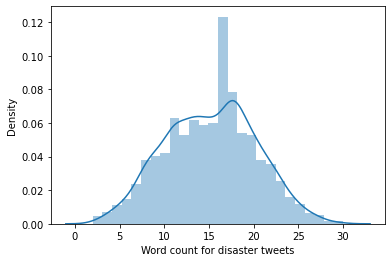

In [8]:
len1=df[df['target']==1]['text'].str.split().map(lambda x: len(x))
x = pd.Series(len1, name="Word count for disaster tweets")
ax1 = sns.distplot(x)

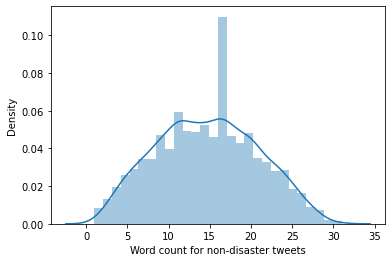

In [9]:
len2=df[df['target']==0]['text'].str.split().map(lambda y: len(y))
y = pd.Series(len2, name="Word count for non-disaster tweets")
ax2 = sns.distplot(y)

### Customized tokenizer

### Tweet tokenizer, Spacey etc

### Dimension reduction using SVD
- Input Data Matrix [m,n] = U [m,r] x Σ [r,r] x 𝑉-transpose [n,r]

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


stops = set(stopwords.words('english'))
stops = map(lambda x:x.lower(),stops)

vectorizer = TfidfVectorizer(use_idf=True, stop_words=stops)

#Learn the vocabulary dictionary and return term-document matrix. 
X = vectorizer.fit_transform(df['text'])

In [21]:
# 7613 tweets, 21637 terms
X.shape

(7613, 21637)

In [12]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [13]:
# here, we compute U [m*r] x Σ [r*r]
# 21637 columns are reduced to 5 
svd.transform(X)

array([[ 0.1314471 , -0.05754923, -0.06732878,  0.03122958, -0.03539631],
       [ 0.02381332,  0.00861317, -0.00743651, -0.01376913,  0.00804908],
       [ 0.11474536, -0.027717  ,  0.03047639, -0.02835933,  0.00689428],
       ...,
       [ 0.08036028,  0.07886652, -0.01406011,  0.01523802, -0.00489219],
       [ 0.06277043, -0.00285174,  0.00656641, -0.0398387 , -0.01545908],
       [ 0.1790993 ,  0.17606749, -0.09346007,  0.17202513, -0.08160155]])

In [14]:
U  = svd.fit_transform(X) / svd.singular_values_
Sigma  = svd.singular_values_
VT = svd.components_

In [23]:
#strength of each column (concept), think of it as coefficient of each concept 
Sigma

array([10.59450634,  7.08210373,  5.60973298,  5.12251492,  4.97957037])

In [25]:
# the coeff. of each term is listed in sigma 
# 0 -> 10.59, 1-> 7.08
# the terms here are less meaningful (the, co, û_, http) bc we haven't done cleaning yet
terms = vectorizer.get_feature_names()
for k in range(0,5):
    for i in (-VT[k]).argsort()[:5]:
        print(k,terms[i])

0 the
0 co
0 http
0 to
0 in
1 http
1 co
1 by
1 û_
1 via
2 you
2 co
2 http
2 your
2 my
3 you
3 the
3 families
3 legionnaires
3 more
4 families
4 from
4 mh370
4 to
4 malaysia


### Model

In [10]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["target"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
stops = set(stopwords.words('english'))
stops = map(lambda x:x.lower(),stops)
vectorizer = TfidfVectorizer(stop_words=stops)
vectorizer.fit(X)

# extract features
x_train = vectorizer.transform(X_train)
x_test = vectorizer.transform(X_test)

In [12]:
print(x_train.shape, x_test.shape)

(5329, 21498) (2284, 21498)


In [13]:
from sklearn.linear_model import LogisticRegression

review_classifier = LogisticRegression(random_state = 0).fit(x_train, y_train)

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

# precision, recall, f1, and average precision below
y_pred = review_classifier.predict(x_test)
print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.85
Recall: 0.65
F1: 0.74
Average Precision: 0.7


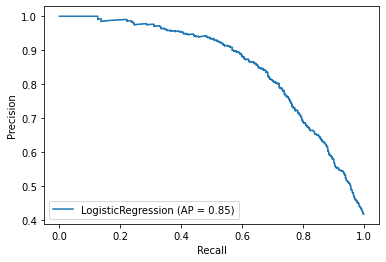

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# plot precision-recall curve
y_pred_prob = review_classifier.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])
plot_precision_recall_curve(estimator=review_classifier, X=x_test, y=y_test)

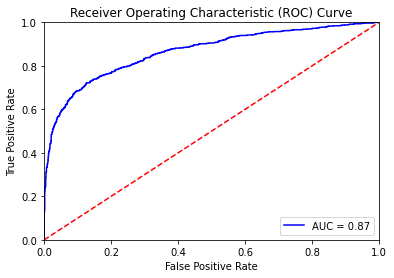

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# plot ROC
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()